## Anomaly Detection Project - Fraud Detection

### Imports

In [138]:
import pandas as pd
import numpy as np
import os
import kagglehub
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

### 1.0 Fetch Raw Data

In [38]:
# Pull dataset from Kaggle
path = kagglehub.dataset_download("ealaxi/paysim1")
print("Path to dataset files:", path)

Path to dataset files: /Users/icarias/.cache/kagglehub/datasets/ealaxi/paysim1/versions/2


In [39]:
filename = os.listdir(path)[0]
print(filename)

PS_20174392719_1491204439457_log.csv


In [40]:
data = pd.read_csv(os.path.join(path, filename))

### 2.0 EDA

##### About the data - *Kaggle*:

"PaySim simulates mobile money transactions based on a sample of real transactions extracted from one month of financial logs from a mobile money service implemented in an African country. The original logs were provided by a multinational company, who is the provider of the mobile financial service which is currently running in more than 14 countries all around the world."

"This synthetic dataset is scaled down 1/4 of the original dataset and it is created just for Kaggle."

In [41]:
data.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [42]:
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [43]:
data.shape

(6362620, 11)

In [44]:
data.describe().round(2)

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6362620.00,6362620.00,6362620.00,6362620.00,6.362620e+06,6.362620e+06,6362620.00,6362620.0
mean,243.40,179861.90,833883.10,855113.67,1.100702e+06,1.224996e+06,0.00,0.0
std,142.33,603858.23,2888242.67,2924048.50,3.399180e+06,3.674129e+06,0.04,0.0
min,1.00,0.00,0.00,0.00,0.000000e+00,0.000000e+00,0.00,0.0
25%,156.00,13389.57,0.00,0.00,0.000000e+00,0.000000e+00,0.00,0.0
50%,239.00,74871.94,14208.00,0.00,1.327057e+05,2.146614e+05,0.00,0.0
75%,335.00,208721.48,107315.18,144258.41,9.430367e+05,1.111909e+06,0.00,0.0
max,743.00,92445516.64,59585040.37,49585040.37,3.560159e+08,3.561793e+08,1.00,1.0


In [37]:
data['isFraud'].value_counts()

isFraud
1    6362620
Name: count, dtype: int64

In [36]:
data['isFlaggedFraud'].value_counts()

isFlaggedFraud
0    6362604
1         16
Name: count, dtype: int64

In [47]:
fraud_count = data['isFraud'].sum()
total_count = len(data)

proportion = fraud_count / total_count
print(f"Fraudulent transaction rate: {proportion * 100:.4f}%")

Fraudulent transaction rate: 0.1291%


#### *Imbalanced Dataset*

The dataset is **highly imbalanced**, with only **~0.13%** of transactions labeled as fraudulent.

Why **Isolation Forest** is a good choice:
- It is an *unsupervised anomaly detection algorithm* that works well in scenarios with very few positive (fraud) cases.
- It's particularly suited for detecting rare, unusual transactions in large datasets like this.

Our data is **labeled** (`isFraud` feature) 
- Although our dataset **contains labels** (`isFraud`), Isolation Forest **does not use them during training**.
- The model learns patterns by identifying anomalies — not by learning from labeled examples.
- Therefore, I will **exclude `isFraud` from the training features**, but **preserve it for evaluation** after prediction.

### 3.0 Data Preprocessing

#### Feature Selection for Fraud Detection (Isolation Forest)

| Column Name        | Description                                      | Keep/Drop | Reason                                                                 |
|--------------------|--------------------------------------------------|-----------|------------------------------------------------------------------------|
| `step`             | Time step (in hours) since simulation started    | ✅ Keep   | May reveal fraud patterns over time (eg. transactions made at certain time of day or a particular sequence)   |
| `type`             | Transaction type (e.g.PAYMENT)                   | ✅ Keep   | Maybe some types are more fraud-prone                                 |
| `amount`           | Transaction amount in local curr                 | ✅ Keep   | High amounts may indicate fraud                                       |
| `nameOrig`         | Sender's account ID                              | ❌ Drop   | Low informational value - may cause issues as the model might memorize specific IDs (overfitting)   |
| `oldbalanceOrg`    | Sender's balance before the transaction          | ✅ Keep   | Can indicate suspicious balance changes                               |
| `newbalanceOrig`   | Sender's balance after the transaction           | ✅ Keep   | Helps detect abnormal drops                                           |
| `nameDest`         | Receiver's account ID                            | ❌ Drop   | Low informational value - see `nameOrig` explanation above ^          |
| `oldbalanceDest`   | Receiver's balance before the transaction        | ✅ Keep   | Useful for spotting suspicious deposits                               |
| `newbalanceDest`   | Receiver's balance after the transaction         | ✅ Keep   | Useful for spotting suspicious deposits                               |
| `isFraud`          | Target variable: 1 = fraud, 0 = not fraud        | ✅ Keep*  | Used **only for evaluating**, not during training                     |
| `isFlaggedFraud`   | Flagged by rule-based system                     | ❌ Drop   | Manual heuristic / unreliable - might only catch obvious frauds  |


In [61]:
# Remove features we won't use
data = data.drop(['nameOrig', 'nameDest', 'isFlaggedFraud'], axis=1)

#### Data Cleansing

In [62]:
# Check if we have null values - if so, remove them
data.isnull().sum()

step              0
type              0
amount            0
oldbalanceOrg     0
newbalanceOrig    0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
dtype: int64

In [64]:
# Check if we have empty string values - if so, remove them
(data == '').sum()

step              0
type              0
amount            0
oldbalanceOrg     0
newbalanceOrig    0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
dtype: int64

In [72]:
# Check if any columns that have only one value across all rows - if so, remove them
data.nunique()

step                  743
type                    5
amount            5316900
oldbalanceOrg     1845844
newbalanceOrig    2682586
oldbalanceDest    3614697
newbalanceDest    3555499
isFraud                 2
dtype: int64

In [66]:
data.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0
1,1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0
2,1,TRANSFER,181.00,181.0,0.00,0.0,0.0,1
3,1,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1
4,1,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0


#### Encoding cateogorical features

In [67]:
# Encode categorical features - Isolation forest only works on numerical data
le = LabelEncoder()
data['type'] = le.fit_transform(data['type'])

In [68]:
data.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,1,3,9839.64,170136.0,160296.36,0.0,0.0,0
1,1,3,1864.28,21249.0,19384.72,0.0,0.0,0
2,1,4,181.00,181.0,0.00,0.0,0.0,1
3,1,1,181.00,181.0,0.00,21182.0,0.0,1
4,1,3,11668.14,41554.0,29885.86,0.0,0.0,0


#### Feature Eng

In [78]:
# the following fields should reconcile to 0 - if the value is non-zero its suspicious
data['errorBalanceOrig'] = data['oldbalanceOrg'] - data['newbalanceOrig'] - data['amount']

data['errorBalanceDest'] = data['newbalanceDest'] - data['oldbalanceDest'] - data['amount']

In [79]:
data.describe().round(2)

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,errorBalanceOrig,errorBalanceDest
count,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00,6.362620e+06,6.362620e+06,6362620.00,6362620.00,6362620.00
mean,243.40,1.71,179861.90,833883.10,855113.67,1.100702e+06,1.224996e+06,0.00,-201092.47,-55567.17
std,142.33,1.35,603858.23,2888242.67,2924048.50,3.399180e+06,3.674129e+06,0.04,606650.46,441528.77
min,1.00,0.00,0.00,0.00,0.00,0.000000e+00,0.000000e+00,0.00,-92445516.64,-13191233.98
25%,156.00,1.00,13389.57,0.00,0.00,0.000000e+00,0.000000e+00,0.00,-249641.09,-29353.04
50%,239.00,1.00,74871.94,14208.00,0.00,1.327057e+05,2.146614e+05,0.00,-68677.26,-3500.49
75%,335.00,3.00,208721.48,107315.18,144258.41,9.430367e+05,1.111909e+06,0.00,-2954.23,0.00
max,743.00,4.00,92445516.64,59585040.37,49585040.37,3.560159e+08,3.561793e+08,1.00,0.01,75885725.63


*Non-zero mean suggests Many transactions are not reconciling correctly*

Could be due to:

* Fraud ($$ sent from/to accounts with incorrect balances)

* The dataset being synthetic 

*Suspicious Scenario*

Consider a transaction where the destination account has zero balance, is supposed to recieve a large amount, but the new balance does not increase:

In [98]:
data[(data['errorBalanceDest'] < 0) & (data['isFraud']==1)].sort_values(by='errorBalanceDest').head(1)

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,errorBalanceOrig,errorBalanceDest
6362506,734,4,10000000.0,11810044.85,1810044.85,0.0,0.0,1,0.0,-10000000.0


In the case above, the record was flagged as fraud, however, what happens when a transaction shows anomalous behaviour but is not labeled as fraud:

In [99]:
data[(data['errorBalanceDest'] < 0) & (data['isFraud']==0)].sort_values(by='errorBalanceDest').head(1)

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,errorBalanceOrig,errorBalanceDest
4340,4,0,130407.77,5347521.57,5477929.34,13060826.21,0.0,0,-260815.54,-13191233.98


- Sender’s balance went **up** after sending money - highly irregular.
- Receiver’s balance dropped to **zero** - not consistent with the transfer amount.

The feature reveals *hidden anomalies* that aren't obvious from raw balance fields alone.

### 4.0 Model Training

In [100]:
X = data.drop(['isFraud'], axis=1)  # All the features (input data)
y = data['isFraud']                # The label column (used only for evaluation)

This function splits your dataset into **training and testing sets**, while keeping the features and labels properly aligned:

| Var      | Significance                                                                   |
| --------- | ---------------------------------------------------------------------------------- |
| `X`       | All input features (e.g., amount, balances, etc.)                                  |
| `y`       | The labels (fraud = 1, not fraud = 0) — used **only for evaluation**, not training |
| `X_train` | 80% of `X` — used to **train** the model                              |
| `X_test`  | 20% of `X` — used to **test** the model on new data (predict fraud)                               |
| `y_train` | 80% of `y` — label alignment with `X_train` (not used as this is an unsupervised algo)          |
| `y_test`  | 20% of `y` — used to evaluate the model’s accuracy (these are the real labels)               |

In [101]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

| Param         | Significance                                                                                |
| ----------------- | ------------------------------------------------------------------------------------------ |
| `test_size=0.2`   | Keep 20% of the data for testing, 80% for training                                         |
| `random_state=42` | Ensures the same split every time you run the code (reproducibility)                       |
| `stratify=y`      | Keeps the **same fraud ratio** in both train and test sets - important for imbalanced data (like fraudulent transactions) |

`stratify` is very important for fraud detection.

* It makes sure that both the training and test sets have the same ratio of fraud vs. non-fraud.
* Without it the test set might end up with no fraud cases, the eval wouldn't work.

In [156]:
# Init the model

isof_model = IsolationForest(
    n_estimators=100,         # Number of trees
    contamination=0.08,  # Approx. 0.1291% fraud rate calculated above - try 0.05
)

In [157]:
# Train the model on X_train 

isof_model.fit(X_train)

,n_estimators,100
,max_samples,'auto'
,contamination,0.08
,max_features,1.0
,bootstrap,False
,n_jobs,None
,random_state,None
,verbose,0
,warm_start,False


### 5.0 Model Validation

In [158]:
# Use the trained model to make predictions on unseen data (X_test)
predictions = isof_model.predict(X_test)

^ This tells the model to analyze each row in X_test and decide whether it’s:

* Normal (not fraud) → returns 1
* Anomaly (possible fraud) → returns -1

In [160]:
predictions = pd.Series(predictions).map({1: 0, -1: 1}) 

^ This translates the model output into the same format as the original dataset's `isFraud` values. This step is necessary for comparison

In [162]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       1.00      0.92      0.96   1270881
           1       0.01      0.38      0.01      1643

    accuracy                           0.92   1272524
   macro avg       0.50      0.65      0.49   1272524
weighted avg       1.00      0.92      0.96   1272524



| Metric                | Importance   | Goal                                       |
| --------------------- | ------------ | ------------------------------------------ |
| **Recall (fraud)**    | Critical  | Catch as many frauds as possible           |
| **Precision (fraud)** | Important | Avoid overwhelming human fraud review teams          |
| **F1-score (fraud)**  | Balanced  | Trade-off between precision & recall       |
| **Accuracy**          | Misleading | Can be 99% even if model misses all frauds - not reliable in this case |


In this scenario, I will use **Recall** as the most important metric in my evaluation. 

Even though precision is not as high, a high recall value ensures my model is flagging as many actual fraudulent transactions as possible. 

Low precision means that I will likely flag more false positives, however this is a trade-off I am comfortable with. These flagged transactions are usually investigated by a team, ensuring that only actual fraud gets reported downstream.

**notes:**

With a contamination level of 0.08, my Isolation Forest model was able to catch 38% of all actual fraud cases in the test set, which is a noticeable improvement in recall compared to earlier runs (around 1% recall). 

This means I’m identifying more fraudulent transactions, a key goal in fraud detection. However, the precision is still very low at 1%, which tells me that most of the transactions flagged as fraud are actually false positives. 

While this reduces my confidence in individual predictions, I understand that it’s a typical trade-off when prioritizing recall in an unsupervised anomaly detection setting. 

The overall accuracy sits at 92%, but I know that this number is misleading due to the class imbalance (the model is naturally biased toward predicting non-fraud). 

Despite the low F1-score for fraud (0.01), I’m encouraged by the improving recall and see this model as a solid first-pass filter to surface suspicious activity for further investigation or to feed into a supervised classifier later on.

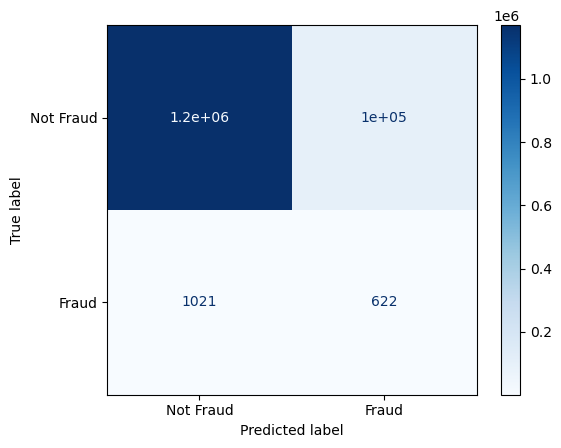

In [166]:
# Confusion matrix
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Fraud', 'Fraud'])
disp.plot(cmap="Blues")